In [3]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

## NLTK

In [175]:
from pymongo import MongoClient
from pprint import pprint
from typing import List
from functools import reduce
from operator import add
from IPython.display import clear_output

# DB CONFIG
client = MongoClient('mongo', 27017)
db = client.music_db
COLLECTION = db['all-songs']


def has_spotify(song):
    return song.get('spotify', {}).get('audio_features')

def has_lyrics(song):
    if not song.get('lyrics'):
        return False
    
    if song.get('lyrics') == 'null':
        return False

    if song.get('lyrics').get('error'):
        return False

    return True


def get_songs(collection):
    return list(collection.find())

songs = get_songs(COLLECTION)
len(songs)

4158

In [176]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

counts = defaultdict(lambda: 0)
for song in songs:
    counts[song['genre']] += 1
    

def compute_weights(counts):
    total = sum(counts.values())
    weights = {}
    for key, val in counts.items():
        weights[key] = val / total * 100
    
    return weights

def vectorize_lyrics(songs):
    lyrics_list = [" ".join(song['tokens']) for song in songs]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list)
    tfidf_array = tfidf_matrix.toarray()
    
    for vector, song in zip(tfidf_array, songs):
        song['tfidf'] = vector
    
    return songs
    
weights = compute_weights(counts)
songs = vectorize_lyrics(songs)

counts, weights

(defaultdict(<function __main__.<lambda>()>,
             {'pop-songs': 1820,
              'latin-songs': 1006,
              'country-songs': 476,
              'rock-songs': 383,
              'christian-songs': 117,
              'rap-song': 356}),
 {'pop-songs': 43.77104377104377,
  'latin-songs': 24.194324194324192,
  'country-songs': 11.447811447811448,
  'rock-songs': 9.211159211159211,
  'christian-songs': 2.813852813852814,
  'rap-song': 8.561808561808562})

In [177]:
import pandas as pd
df = pd.DataFrame(songs)
df = df.drop(columns=['_id', 'id', 'identifier', 'isNew', 'lastPos', 'peakPos', 'rank', 'weeks', 'track_href', 'type', 'uri', 'spotify', 'analysis_url'])
df.head()

acousticness               artist  danceability  duration_ms   emotion  \
0      0.892000          Post Malone         0.680       203778  0.100230   
1      0.982000         Selena Gomez         0.400       228870 -0.025386   
2      0.207000        Ariana Grande         0.327       190023  0.163503   
3      0.000041                Drake         0.624       202456  0.073871   
4      0.981000  5 Seconds Of Summer         0.552       233603  0.019088   

   energy gender      genre  instrumentalness  key   ...    \
0   0.263    NaN  pop-songs             0.000    1   ...     
1   0.169    NaN  pop-songs             0.954    6   ...     
2   0.532    NaN  pop-songs             0.874    3   ...     
3   0.546    NaN  pop-songs             0.845    8   ...     
4   0.139   None  pop-songs             0.937    7   ...     

                                              lyrics  mode  \
0  {'result': {'artist': {'name': 'Post Malone'},...     0   
1  {'result': {'artist': {'name': 'Selena Gomez'}...     1   
2  {'result': {'artist': {'name': 'Ariana Grande'...     0   
3  {'result': {'artist': {'name': 'Drake'}, 'trac...     1   
4  {'result': {'artist': {'name': '5 Seconds of S...     0   

                                          raw_lyrics  speechiness    tempo  \
0  You probably think that you are better now, be...       0.9300   97.262   
1  Took you like a shot\nThought that I could cha...       0.0479   95.995   
2  You, you love it how I move you\nYou love it h...       0.0397  144.060   
3  Trap, trap money benny\nThis shit got me in my...       0.2200  183.329   
4  Remember the words you told me, "love me 'til ...       0.0408  169.628   

                                               tfidf  time_signature  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...               4   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...               4   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...               4   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...               4   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...               3   

            title                                             tokens valence  
0      Better Now  [probabl, think, better, better, say, caus, im...  0.6840  
1     Back To You  [took, like, shot, thought, could, chase, cold...  0.0794  
2  God Is A Woman  [love, move, love, touch, one, said, done, you...  0.0546  
3  In My Feelings  [trap, trap, money, benni, shit, got, feel, go...  0.1600  
4      Youngblood  [rememb, word, told, love, til, day, die, surr...  0.1660  

[5 rows x 22 columns]

In [179]:
from typing import List

STR_COLS = ['title', 'lyrics', 'artist', 'gender', 'tfidf', 'tokens']   # Remove columns with string as names

USE_ONLY = []#['tempo', 'raw_lyrics']

GENRES = ['pop-songs', 'rock-songs']

# Assign colum names to the dataset
names = list(df.columns.values)

# Read dataset to pandas dataframe
dataset_copy = df
dataset = dataset_copy.drop(columns=STR_COLS)

# Lyric Counts
dataset['raw_lyrics'] = dataset_copy['raw_lyrics'].apply(lambda lyrics: len("".join(lyrics.split('\n'))))
dataset.head()

if USE_ONLY:
    dataset = dataset[USE_ONLY + ['genre']]
    
    
def select_genres(df, genres: List):
    if not genres: return df
    indexes = df['genre'] == genres.pop()
    for genre in genres:
        indexes |=  df['genre'] == genre
    return df[indexes]
    
dataset = select_genres(dataset, GENRES) #dataset[(df['genre'] == 'country-songs') | (df['genre'] == 'rap-song')]
dataset.head()

acousticness  danceability  duration_ms   emotion  energy      genre  \
0      0.892000         0.680       203778  0.100230   0.263  pop-songs   
1      0.982000         0.400       228870 -0.025386   0.169  pop-songs   
2      0.207000         0.327       190023  0.163503   0.532  pop-songs   
3      0.000041         0.624       202456  0.073871   0.546  pop-songs   
4      0.981000         0.552       233603  0.019088   0.139  pop-songs   

   instrumentalness  key  liveness  loudness  mode  raw_lyrics  speechiness  \
0             0.000    1    0.1390   -15.722     0        2500       0.9300   
1             0.954    6    0.1140   -12.988     1        2008       0.0479   
2             0.874    3    0.0888    -8.440     0        1942       0.0397   
3             0.845    8    0.1100    -9.578     1        1909       0.2200   
4             0.937    7    0.1000   -12.590     0        2071       0.0408   

     tempo  time_signature  valence  
0   97.262               4   0.6840  
1   95.995               4   0.0794  
2  144.060               4   0.0546  
3  183.329               4   0.1600  
4  169.628               3   0.1660

## PairPlot

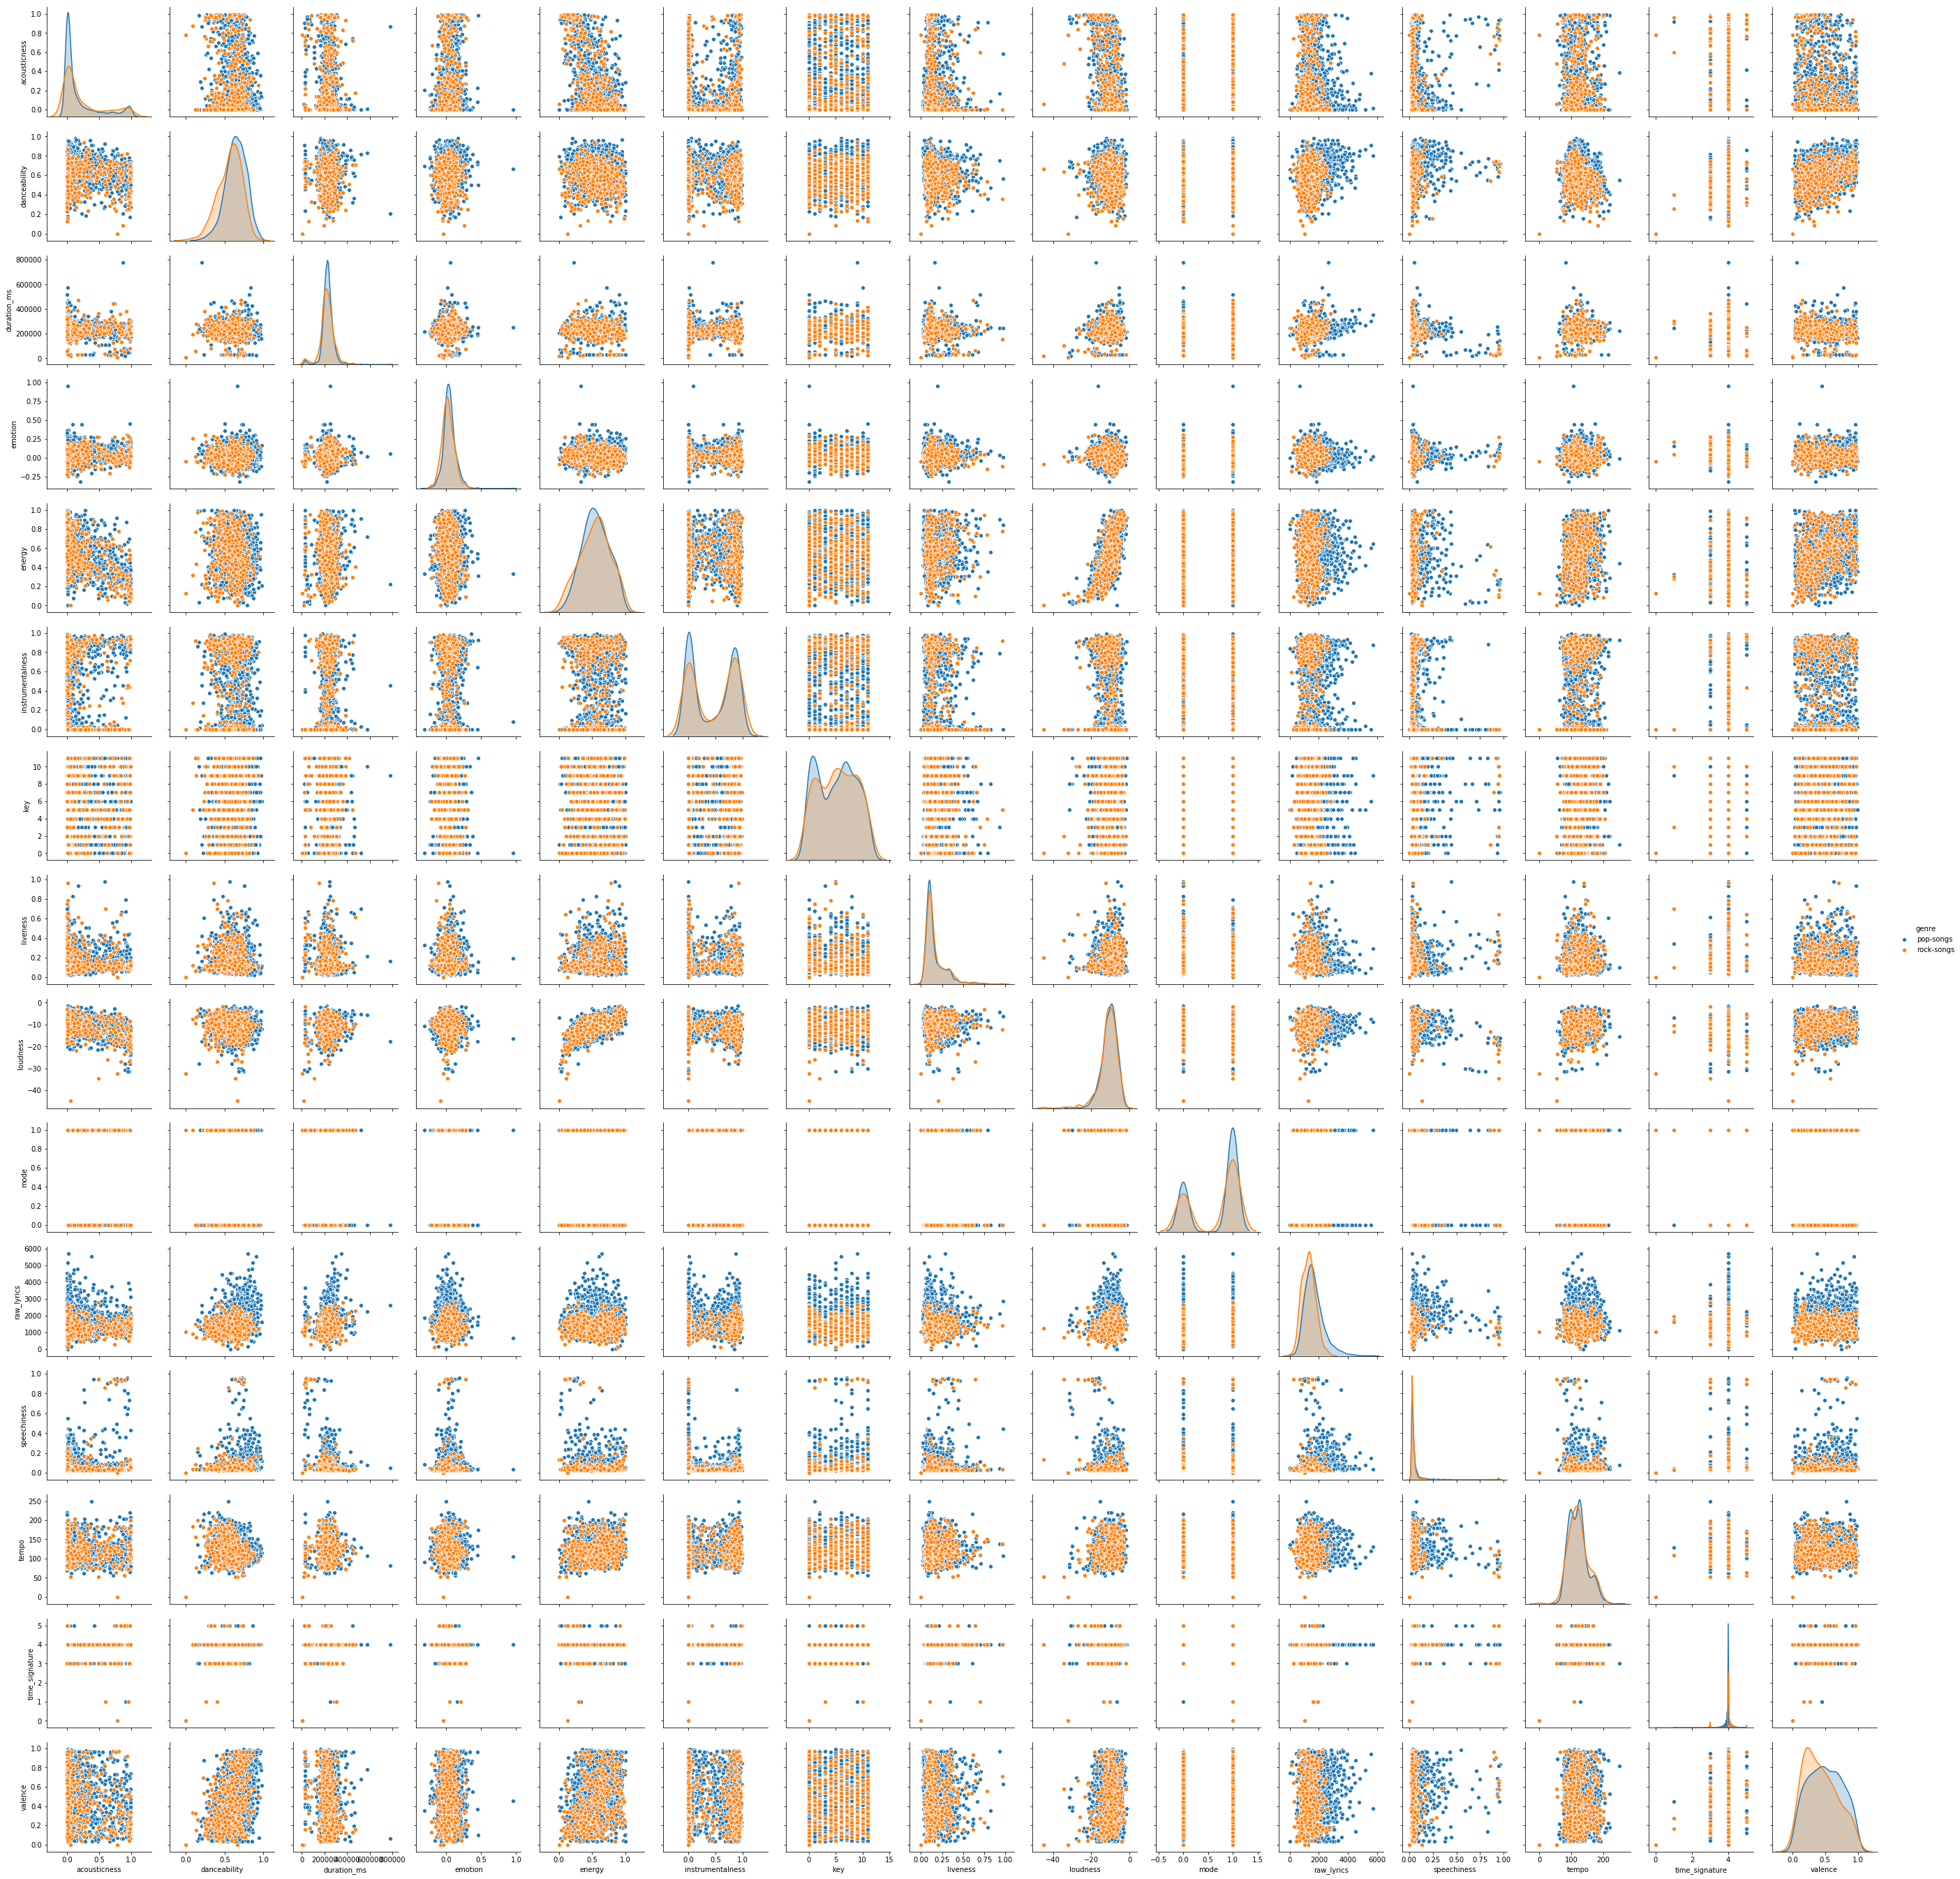

In [180]:
import seaborn as sns
sns_plot = sns.pairplot(dataset, hue='genre')
sns_plot.savefig("pairplot.png") 

## Feature Selection

In [181]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, selector: VarianceThreshold):
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

selector = VarianceThreshold(threshold=.1)
dataset_selected = variance_threshold_selector(dataset.drop(columns='genre'), selector)
dataset_selected.head()

duration_ms  instrumentalness  key  loudness  mode  raw_lyrics    tempo
0       203778             0.000    1   -15.722     0        2500   97.262
1       228870             0.954    6   -12.988     1        2008   95.995
2       190023             0.874    3    -8.440     0        1942  144.060
3       202456             0.845    8    -9.578     1        1909  183.329
4       233603             0.937    7   -12.590     0        2071  169.628

In [182]:
y = dataset['genre'].values
X = dataset_selected.values
dataset = dataset_selected
print(len(dataset), len(dataset_selected))

2203 2203


## Data transformation

In [183]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [184]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

## PCA

In [185]:
## PCA
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
from sklearn.decomposition import PCA as sklearnPCA
tls.set_credentials_file(username='jamesaud', api_key='UcfFgtJVY9P2x0dihNVS')

pca = sklearnPCA(n_components=2)
Y_sklearn = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([ 0.19259162,  0.16587504])

In [186]:
trace = Scatter(
        x=Y_sklearn[:,0],
        y=Y_sklearn[:,1],
        mode='markers',
        name="PCA",
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))

data = Data([trace])
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:

In [187]:

traces = []

for name in set(y):
    trace = Scatter(
        x=Y_sklearn[y_train==name,0],
        y=Y_sklearn[y_train==name,1],
        mode='markers',
        name=name,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:

In [188]:
def misclassifications(y_test, y_pred):
    classifications = defaultdict(lambda: defaultdict(lambda: 0))
    for real, pred in zip(y_test, y_pred):
        classifications[real][pred] += 1
    return classifications  

def error_graph(classifier, i_attribute: str, i_start=1, i_end=40, **kwargs):
    
    error = []
    i_att = {i_attribute: 0}
    
    
    # Calculating error for K values between 1 and 40
    for i in range(i_start, i_end):  
        i_att[i_attribute] = i
        clsfy = classifier(**i_att, **kwargs)
        clsfy.fit(X_train, y_train)
        pred_i = clsfy.predict(X_test)
        error.append(np.mean(pred_i != y_test))
    
    plt.figure(figsize=(12, 6))  
    plt.plot(range(i_start, i_end), error, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title(f'Error Rate {clsfy} Value')  
    plt.xlabel('K Value')  
    plt.ylabel('Mean Error')  

# Resample

In [201]:
from sklearn.utils import resample
from collections import Counter

def max_count(lst):
    return Counter(lst).most_common(1)[0][1]


df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=max_count(y_train),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.balance.value_counts()

X_balanced_train = None

NameError: name 'df_minority' is not defined

## KNN CLASSIFICATION

from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

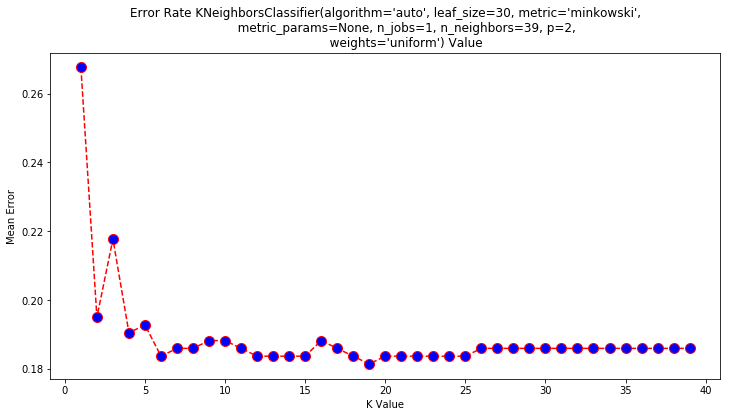

In [192]:
from sklearn.neighbors import KNeighborsClassifier  

error_graph(KNeighborsClassifier, "n_neighbors")

In [195]:
classifier = KNeighborsClassifier(n_neighbors=6)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)
y_pred[:3]

array(['pop-songs', 'pop-songs', 'pop-songs'], dtype=object)

In [196]:
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix  
from pandas import DataFrame
import matplotlib.pyplot as plt

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
pprint(misclassifications(y_test, y_pred))

[[357   2]
 [ 79   3]]
             precision    recall  f1-score   support

  pop-songs       0.82      0.99      0.90       359
 rock-songs       0.60      0.04      0.07        82

avg / total       0.78      0.82      0.74       441

defaultdict(<function misclassifications.<locals>.<lambda> at 0x7fd502e18d90>,
            {'pop-songs': defaultdict(<function misclassifications.<locals>.<lambda>.<locals>.<lambda> at 0x7fd502e18a60>,
                                      {'pop-songs': 357,
                                       'rock-songs': 2}),
             'rock-songs': defaultdict(<function misclassifications.<locals>.<lambda>.<locals>.<lambda> at 0x7fd50295de18>,
                                       {'pop-songs': 79,
                                        'rock-songs': 3})})


## DECISION TREE CLASSIFICATION 

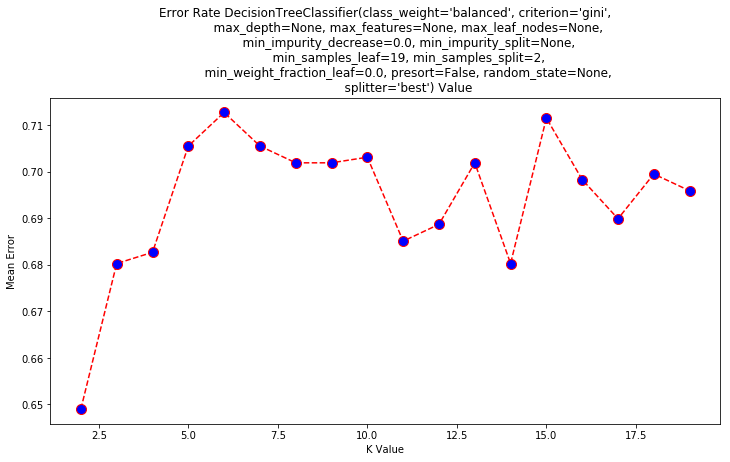

In [153]:
from sklearn.tree import DecisionTreeClassifier

error_graph(DecisionTreeClassifier, "min_samples_leaf", i_start=2, i_end=20, class_weight='balanced')

In [165]:
dtree = DecisionTreeClassifier(min_samples_leaf=2, class_weight='balanced')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)  

In [166]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
misclassifications(y_test, y_pred)

[[ 10   7   9   4   0   0]
 [  5  36  13  26   2  13]
 [ 10  15  85  53  20  16]
 [ 23  42  91 101  41  52]
 [  2   4   7  26  38   4]
 [  5  15  15  28   2  12]]
                 precision    recall  f1-score   support

christian-songs       0.18      0.33      0.24        30
  country-songs       0.30      0.38      0.34        95
    latin-songs       0.39      0.43      0.41       199
      pop-songs       0.42      0.29      0.34       350
       rap-song       0.37      0.47      0.41        81
     rock-songs       0.12      0.16      0.14        77

    avg / total       0.36      0.34      0.34       832



defaultdict(<function __main__.misclassifications.<locals>.<lambda>()>,
            {'pop-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'rap-song': 41,
                          'christian-songs': 23,
                          'latin-songs': 91,
                          'country-songs': 42,
                          'pop-songs': 101,
                          'rock-songs': 52}),
             'latin-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'pop-songs': 53,
                          'latin-songs': 85,
                          'rap-song': 20,
                          'christian-songs': 10,
                          'country-songs': 15,
                          'rock-songs': 16}),
             'rap-song': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'latin-s

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.233813 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.233813 to fit



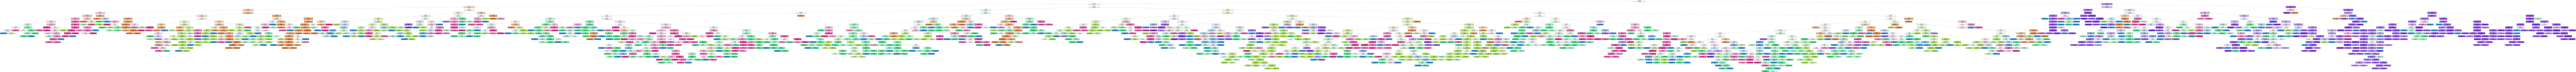

In [161]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


colums = list(dataset.columns.values)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=colums,
                class_names=dtree.classes_)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

In [162]:
# Bag of words
# TfIDF
# Length of lyrics
# Lyric emotion
# Song title

## Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

dtree = RandomForestClassifier(class_weight='balanced')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)  

In [167]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
misclassifications(y_test, y_pred)

[[ 10   7   9   4   0   0]
 [  5  36  13  26   2  13]
 [ 10  15  85  53  20  16]
 [ 23  42  91 101  41  52]
 [  2   4   7  26  38   4]
 [  5  15  15  28   2  12]]
                 precision    recall  f1-score   support

christian-songs       0.18      0.33      0.24        30
  country-songs       0.30      0.38      0.34        95
    latin-songs       0.39      0.43      0.41       199
      pop-songs       0.42      0.29      0.34       350
       rap-song       0.37      0.47      0.41        81
     rock-songs       0.12      0.16      0.14        77

    avg / total       0.36      0.34      0.34       832



defaultdict(<function __main__.misclassifications.<locals>.<lambda>()>,
            {'pop-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'rap-song': 41,
                          'christian-songs': 23,
                          'latin-songs': 91,
                          'country-songs': 42,
                          'pop-songs': 101,
                          'rock-songs': 52}),
             'latin-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'pop-songs': 53,
                          'latin-songs': 85,
                          'rap-song': 20,
                          'christian-songs': 10,
                          'country-songs': 15,
                          'rock-songs': 16}),
             'rap-song': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'latin-s

## Feed forward neural net

In [171]:
from sklearn.neural_network import MLPClassifier

genre_int_lookup = {genre: i for i, genre in enumerate(set(y_test))}

def lookup(genre):
    return genre_int_lookup[genre]

y_ints = list(map(lookup, y))
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(1000, 200, 20), random_state=1)
clf.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 200, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [172]:
# Actulaly shouldn't be a classification problem, but a regression problem!
y_pred = clf.predict(X_test)

In [173]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
misclassifications(y_test, y_pred)

[[  0   0   0  22   0   8]
 [  0   0   0  49   0  46]
 [  0   0   0 133   0  66]
 [  2   0   0 220   0 128]
 [  0   0   0  44   1  36]
 [  0   0   0  50   0  27]]
                 precision    recall  f1-score   support

christian-songs       0.00      0.00      0.00        30
  country-songs       0.00      0.00      0.00        95
    latin-songs       0.00      0.00      0.00       199
      pop-songs       0.42      0.63      0.51       350
       rap-song       1.00      0.01      0.02        81
     rock-songs       0.09      0.35      0.14        77

    avg / total       0.28      0.30      0.23       832



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



defaultdict(<function __main__.misclassifications.<locals>.<lambda>()>,
            {'pop-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'rock-songs': 128,
                          'pop-songs': 220,
                          'christian-songs': 2}),
             'latin-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'pop-songs': 133, 'rock-songs': 66}),
             'rap-song': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'pop-songs': 44, 'rock-songs': 36, 'rap-song': 1}),
             'country-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'rock-songs': 46, 'pop-songs': 49}),
             'rock-songs': defaultdict(<function __main__.misclassifications.<locals>.<lambda>.<locals>.<lambda>()>